# Homework6 Statistical Estimation

In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from scipy.io import loadmat

## Maximum likelihood estimation of an increasing nonnegative signal
Given signal $y(t)$, $h(t)$, and the convolution relationship $$y(t) = \sum_{\tau=1}^{k}h(\tau)x(t-\tau) + v(t)$$
where v(t) are independent gaussian $\mathcal{N}(0,I)$ variables.

To estimate $x(t)$, we formulate this into max-likelihood problem:
$$\text{find }x, \text{ maximize }\quad log\frac{1}{2\pi}e^{-\frac{1}{2}(y-h*x)^T(y-h*x)} = -\frac{1}{2}\|y-h*x\|_2^2 + c$$
We add nonnegativity and monotinicity constraints on $x(t)$, with compared to the problem without these constraints.

In [2]:
# loading data from matlab
data = loadmat("./data_ml_estim.mat")
print("The file contains " + str(data.keys()))

N, k = data['N'][0, 0], data['k'][0, 0]
xtrue = data['xtrue'][:, 0]
h = data['h'][0, :]
y = data['y']

The file contains dict_keys(['__header__', '__version__', '__globals__', 'N', 'h', 'k', 'xtrue', 'y'])


With constraints, the optimal: 50465.6551
Without constraints on nonnegativity and monotonity, the optimal: 57785.6634


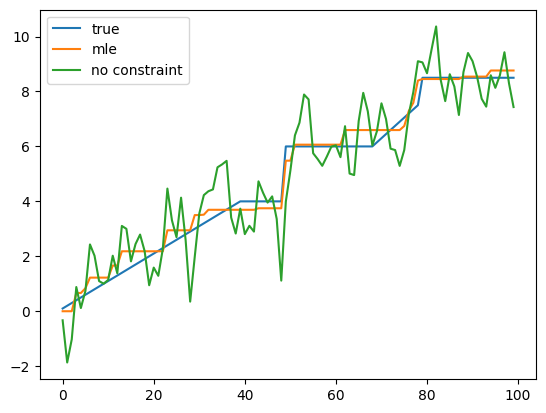

In [3]:
x = cp.Variable(N)
# constrains on nonnegativity and monotinicity
cst = [cp.diff(x, k=1) >= 0, x[0] >= 0]
obj = cp.Minimize(cp.sum_squares(y - cp.conv(h, x)[:-(k-1)]))
prob = cp.Problem(obj, cst)

prob.solve()
print("With constraints, the optimal: %.4f" % prob.value)

plt.plot(xtrue)
plt.plot(x.value)

# without constraints
prob2 = cp.Problem(obj, [])
prob2.solve()
print("Without constraints on nonnegativity and monotonity, the optimal: %.4f" % prob2.value)

plt.plot(x.value)
plt.legend(['true', 'mle', 'no constraint'])
plt.show()
plt.close()

## Worst-case probability of loss
We have two gaussian random variables $R_1$, $R_2$ and their marginal distribution $p_1$, $p_2$ respectively.  
We need to find the optimal joint distribution of $R_1$ and $R_2$ to maximize $prob(R_1 + R_2 \leq 0)$

Given the specific case:
$$\mu_1 = 8 \quad \mu_2 = 20 \quad \sigma_1 = 6 \quad \sigma_2=17.5 \quad \rho = -0.25$$  
Discretize the value of $r_i$ to 100 points from -30 to 70:
$$p_i^{(k)} = prob(R_k = r_i) = \frac{exp(-(r_i-\mu_k)^2/2\sigma_1^2)}{\sum exp(-(r_i-\mu_k)^2/2\sigma_1^2)}$$

In [4]:
# data preprocessing
mu1, mu2, sigma1, sigma2, rho = 8, 20, 6, 17.5, -0.25
N = 100
r = np.linspace(-30, 70, N)
p1 = np.exp(-(r - mu1)**2 / (2 * sigma1**2))
p1 /= p1.sum()
p2 = np.exp(-(r - mu2)**2 / (2 * sigma2**2))
p2 /= p2.sum()

tmp2 = np.ones((N, 1)) @ np.reshape(r, (1, N))
tmp1 = np.reshape(r, (N, 1)) @ np.ones((1, N))
mask = (tmp1 + tmp2) <= 0

The worse case probability is 	 0.1920


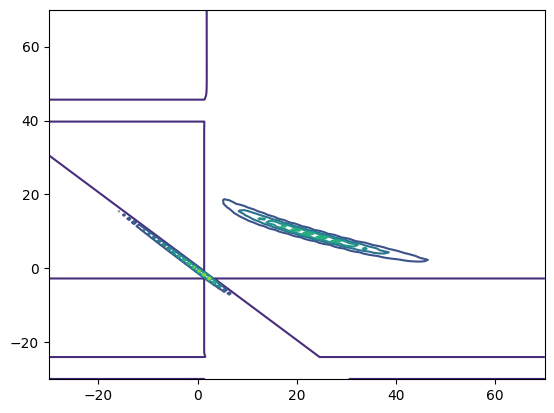

In [5]:
P = cp.Variable((N, N))
# marginal distribution + nonnegative probability + correlation
cst = [P >= 0, cp.sum(P, axis=1) == p1, cp.sum(P, axis=0) == p2,
       cp.quad_form(r, P) -mu1 * mu2 == rho * sigma1 * sigma2]
obj = cp.Maximize(cp.sum(cp.multiply(mask, P)))
prob = cp.Problem(obj, cst)
print("The worse case probability is \t %.4f" % prob.solve())

xv, yv = np.meshgrid(r, r)
plt.contour(xv, yv, P.value)
plt.show()
plt.close()

### Joint gaussian distribution
$$R_1 + R_2 \sim \mathcal{N}(\mu_1 + \mu_2, \sigma_1^2 + \sigma_2^2 + \rho * \sigma_1 + \sigma_2)$$

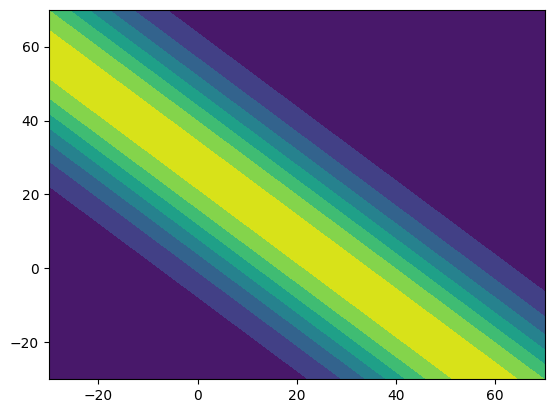

In [6]:
sigma_joint = np.sqrt(sigma1**2 + sigma2**2 + rho * sigma1 * sigma2)
mu_joint = mu1 + mu2
p_joint = np.exp(-0.5 * np.square((tmp1 + tmp2 - mu_joint) / sigma_joint)) / sigma_joint / np.sqrt(2 * np.pi)
plt.contourf(xv, yv, p_joint)
plt.show()
plt.close()